In [1]:
import wandb
wandb.init(project='ChannelCharting')

W&B Run: https://app.wandb.ai/evs/ChannelCharting/runs/lr9ii429

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("../src")
import data_preparation

In [4]:
# read data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")

In [5]:
#one sample example
imag_mean = np.mean(np.imag(data))
imag_std = np.std(np.imag(data))
real_mean = np.mean(np.real(data))
real_std = np.std(np.real(data))
one_sample = data[0:2,:,25:75]
one_sample_real = (np.real(one_sample) - real_mean)/real_std
one_sample_imag = (np.imag(one_sample) - imag_mean)/imag_std

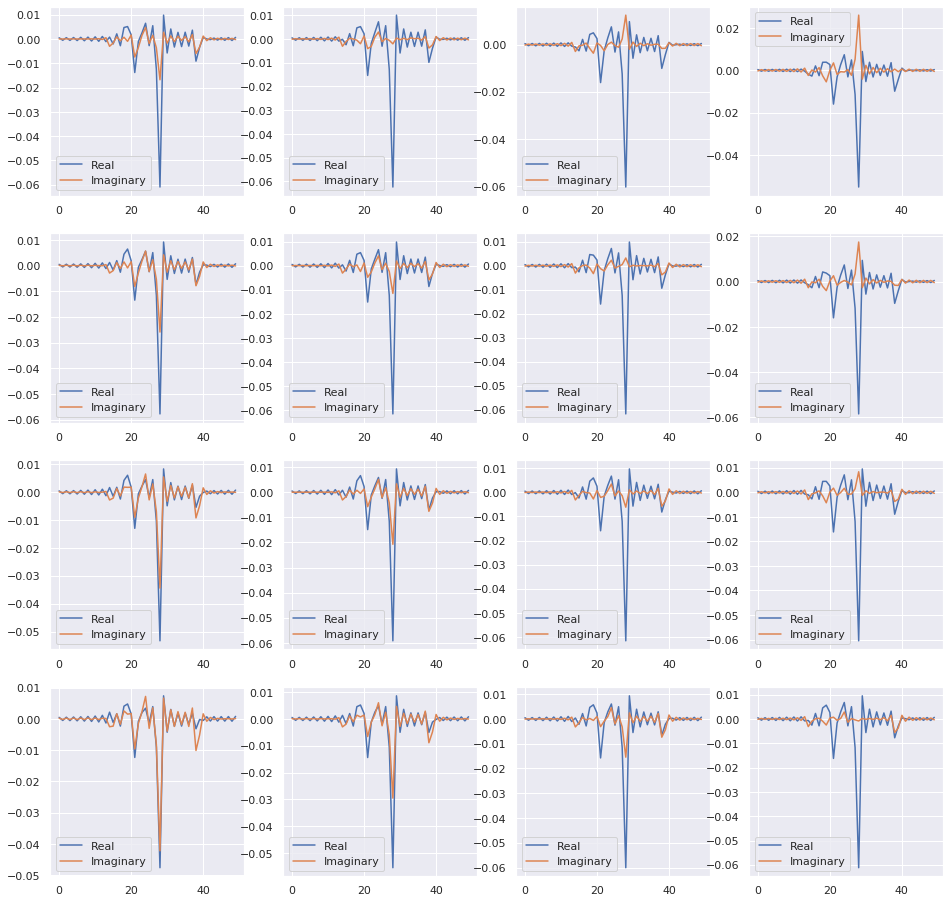

In [6]:
plt.figure(figsize=(16,16))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(one_sample_real[0, i-1, :], label='Real')
    plt.plot(one_sample_imag[0, i-1, :], label='Imaginary')
    plt.legend()

In [7]:
one_sample_full = np.concatenate([one_sample_real, one_sample_imag], axis=0)

In [8]:
one_sample_full.shape

(4, 16, 50)

We observe that a lot of information is contained on the imaginary part of the impulse. So the 16 antennas, we are gong to have 32 'Channels' for our dataset. 
So we will have a training batch of shape [batch_size, 32 , 100].

# Siamese Neural Network

In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## Setting up the Custom Dataset

In [10]:
# undersampling
idces = np.random.randint(0, data.shape[0], int(0.3*data.shape[0]))
data_undersampled = data[idces]

In [11]:
data_undersampled.shape

(7176, 16, 100)

In [12]:
data_undersampled.shape
# train test split
train, test= train_test_split(data_undersampled)

In [13]:
train_dataset = data_preparation.SiameseDataset(train)
scaler = train_dataset.scaler_real, train_dataset.scaler_imag
test_dataset = data_preparation.SiameseDataset(test, scaler)

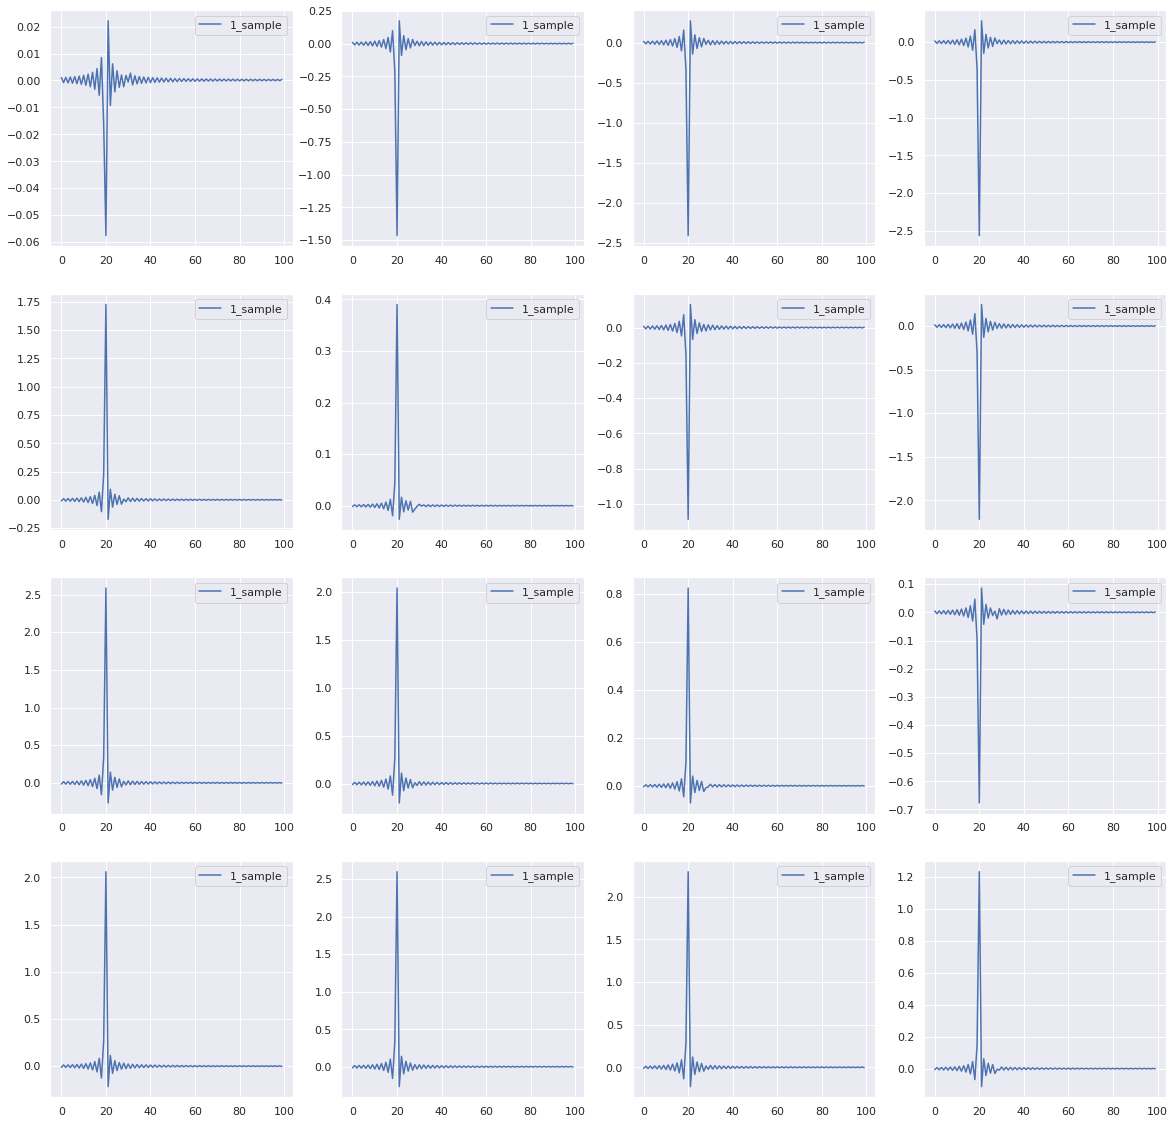

In [14]:
plt.figure(figsize=(20,20))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(train_dataset[0][0][i-1, :], label='1_sample')
    #plt.plot(train_dataset[0][1][i-1, :], label='2_sample')
    plt.legend()

In [15]:
train_dataset.nb_channels()

32

In [16]:
class SimpleNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_dataset.nb_channels(),
                          out_channels=128,
                          kernel_size=16)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, 
                          out_channels=64,
                          kernel_size=8)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64,
                          out_channels=16,
                          kernel_size=4)
        
        f = data_preparation.conv1d_output_size
        self.features = f(f(f(train_dataset.nb_samples(),kernel_size=16),
                                                       kernel_size=8), 
                                                         kernel_size=4)

        
        
        self.lin1 = nn.Linear(in_features= 16 * self.features, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=32)
        self.lin3 = nn.Linear(in_features=32, out_features=8)
        self.lin4 = nn.Linear(in_features=8, out_features=3)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.dropout(F.relu(self.lin2(x)))
        x = self.dropout(F.relu(self.lin3(x)))
        
        out = self.lin4(x)
        
        return out
        
    

In [17]:
model = SimpleNN()
wandb.watch(model)


In [23]:
def loss_function(x1, x2, y1, y2):
    x_difference = torch.sum(torch.abs(x1 - x2), dim=[1,2])
    #print(x_difference)
    y_difference = torch.sum(torch.abs(y1 - y2), dim=[1])
    #print(y_difference)
    return torch.sum(torch.pow(x_difference - y_difference, 2)/x_difference) 

In [19]:
#x1, x2 = train_dataset[0:10][0], train_dataset[0:10][1]
#y1, y2 = model(x1), model(x2)

## Training

In [20]:
a = len(test_dataset)/len(train_dataset)
batch_size = 64

In [21]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
criterion = loss_function
optimizer = optim.Adam(model.parameters())


In [22]:
wandb.log({"Batch_size": batch_size,
           "Dropout": dropout
          })
for e in range(80):
    # train
    loss = 0
    
    for x1, x2 in train_loader:
        
        optimizer.zero_grad()
        y1, y2 = model(x1), model(x2)
        
        batch_loss = criterion(x1, x2, y1 ,y2)
        
        batch_loss.backward()
        optimizer.step()
    
        loss+=batch_loss
    
    #validation
    model.eval()
    val_loss = 0
    for x1, x2 in test_loader:
        y1, y2 = model(x1), model(x2)
        val_loss += criterion(x1, x2, y1 ,y2)
    
    wandb.log({
        "Training Loss": loss,
        "Validation Loss": a*val_loss,
    })
    print(f"Epoch {e+1}, Training Loss: {a*loss}, Validation Loss: {val_loss}")

tensor([1.4248e-01, 5.9674e+00, 5.3857e+00, 1.0556e+02, 1.2302e+02, 4.4599e-03,
        1.4995e+02, 2.3081e+03, 1.2603e+00, 4.2738e+02, 4.6489e+01, 1.2520e+01,
        5.3430e+01, 1.5963e+01, 2.8487e+01, 3.0617e+01, 2.3085e+01, 6.8371e+01,
        2.3576e+00, 1.0474e+00, 1.0762e+02, 4.4848e+01, 6.6493e+01, 3.0131e+01,
        6.9752e+00, 1.8505e+01, 2.1950e+00, 7.2466e+00, 3.3958e+00, 2.3347e+00,
        1.6910e+01, 3.2495e+01, 5.0143e+01, 4.6267e+00, 2.3194e+01, 6.9469e-01,
        1.0465e+03, 3.2626e+01, 9.6299e+00, 8.0554e+00, 3.0991e+01, 3.8353e+01,
        1.2391e+01, 1.1351e+01, 1.7613e+02, 1.3467e+03, 2.8498e+01, 8.9231e+00,
        3.7613e+01, 9.7292e+01, 1.2396e+01, 5.2680e+01, 6.6362e-01, 2.0344e+02,
        3.8168e+02, 3.7751e+01, 1.8740e+03, 4.4927e+01, 8.2294e+01, 2.1176e+02,
        1.6553e+00, 2.2319e+01, 1.0987e+01, 3.4531e-01])
tensor([1.2480e-06, 1.0498e-05, 4.7278e-05, 4.7013e-04, 2.3896e-03, 1.1176e-08,
        1.7384e-03, 9.6194e-03, 5.9344e-06, 2.2151e-03, 1.2229e

tensor([1.1611e+02, 3.4752e+00, 9.2170e+01, 1.3481e+02, 6.9130e+00, 2.0981e+02,
        2.0543e+01, 3.0103e+01, 2.3352e-02, 1.9058e+00, 1.4151e+03, 2.4687e+01,
        9.7752e+00, 4.0039e+00, 3.5903e-01, 5.0734e-01, 9.5059e+01, 2.7370e-02,
        3.2317e+01, 1.3089e-01, 2.3165e-01, 6.4415e+00, 4.1150e+01, 1.2766e+02,
        8.2106e+02, 4.7962e+01, 4.3109e+01, 9.3852e+01, 6.6575e+00, 1.9541e+01,
        4.0820e-01, 4.3060e-01, 9.2708e-03, 1.2381e+02, 2.9540e+01, 1.2901e+01,
        5.6787e-01, 4.2594e-01, 1.5687e+02, 1.6825e-01, 6.2159e+01, 8.0532e-03,
        1.8540e+01, 6.5385e+01, 4.8541e-01, 6.1334e+01, 8.5959e+01, 7.0989e+00,
        7.1054e+01, 3.9080e-02, 1.2043e+01, 7.2409e-01, 9.6506e+01, 1.3719e+01,
        7.2673e+01, 5.1016e+01, 1.2595e+02, 2.0315e+00, 2.9106e-01, 4.6241e+00,
        1.0659e+02, 5.2141e-05, 1.1313e+02, 5.4994e+00])
tensor([1.3725e-01, 2.9803e-04, 1.3748e-01, 1.3685e-01, 8.3994e-04, 4.1281e-02,
        1.7519e-02, 2.9819e-02, 4.0606e-07, 3.0295e-04, 5.9551e

tensor([1.7638e+02, 1.6289e+01, 9.1430e+00, 4.0446e+02, 1.0273e+03, 8.0689e+00,
        1.1234e+01, 1.1472e+02, 7.9318e-01, 9.9373e-02, 3.3930e+01, 1.6661e+02,
        6.6967e+02, 2.8540e+01, 7.9019e+01, 1.7278e+01, 3.1113e+00, 4.8225e+00,
        2.2881e-01, 9.1132e+01, 2.2720e+03, 1.9924e+02, 9.4493e+01, 5.2025e+01,
        1.8947e+01, 2.6364e+00, 8.5714e+00, 1.1836e+01, 7.3103e+00, 2.8101e+01,
        1.4014e+01, 1.1923e+02, 7.0925e+01, 1.4468e-01, 2.4967e-01, 1.2578e+01,
        7.4331e+01, 7.4524e+01, 4.4063e-02, 2.8327e+00, 3.9473e-01, 5.0414e+01,
        2.9136e+01, 1.4179e+00, 6.5120e+01, 2.3656e+01, 2.5169e+00, 4.1073e-03,
        5.5143e+00, 1.6096e+01, 2.2619e+02, 5.7840e-02, 1.9233e+02, 5.3921e-01,
        8.9522e+01, 5.8014e+00, 5.4357e+01, 1.1841e+02, 1.4941e+00, 2.5330e-01,
        9.9696e-02, 1.2537e+00, 2.0440e+01, 6.0749e+00])
tensor([1.9388e+00, 1.7053e-01, 1.1019e-01, 2.5328e+00, 3.4304e+00, 2.0523e-02,
        5.0592e-02, 8.3331e-01, 4.8462e-03, 5.2482e-05, 4.4884e

tensor([1.3824e+02, 1.3324e+00, 5.8134e+01, 2.3180e+01, 3.1741e-01, 5.5355e+01,
        9.2711e-01, 3.5918e+01, 6.0749e+01, 7.1182e+01, 5.5414e+03, 1.6515e+01,
        4.2582e+01, 9.2468e+00, 1.9763e+02, 2.6331e+01, 6.2850e+00, 1.3147e+02,
        1.9254e-02, 2.1457e+00, 6.4134e+00, 9.4231e+02, 8.2353e+02, 2.6384e+00,
        1.0173e+01, 1.1835e+02, 1.9184e+02, 2.6089e+00, 5.8619e+00, 8.5766e+01,
        9.1394e-01, 2.6331e+01, 5.8532e+01, 2.7536e+01, 1.2516e+02, 1.8200e+00,
        3.5930e+02, 2.6904e+00, 1.5108e+02, 2.1196e+01, 1.2648e+02, 2.0173e+00,
        1.8223e+00, 9.3038e+01, 6.4019e+01, 1.2451e+02, 2.4340e+01, 3.9603e+01,
        1.4624e+01, 2.8619e+02, 4.1799e+00, 2.5941e+01, 1.0807e+00, 1.7722e+02,
        1.3900e+02, 4.2189e+00, 2.0172e+00, 8.3576e-01, 5.8602e+01, 1.1210e+02,
        4.5025e+02, 3.9086e+01, 6.4628e-01, 1.2016e+02])
tensor([8.7403e+00, 3.3386e-02, 1.4325e+00, 1.5297e+00, 2.1755e-03, 2.8538e+00,
        9.2458e-03, 9.2157e-01, 3.6763e+00, 4.5942e+00, 1.8630e

tensor([5.9743e-02, 1.1220e+01, 4.8731e+00, 3.1420e+01, 1.3261e+02, 7.5873e+03,
        1.1184e+02, 8.7299e+01, 8.7616e+01, 6.6403e-01, 4.4573e+02, 2.8723e+03,
        1.4276e+02, 3.1065e+01, 2.2084e+03, 8.2532e+00, 1.6733e+02, 1.7917e-01,
        8.8748e-01, 1.5863e+02, 6.7146e+00, 1.7859e+00, 1.8359e+01, 3.8941e+02,
        2.0355e+02, 1.3357e+02, 5.7592e+03, 9.2043e-02, 2.0407e+01, 1.1813e+01,
        7.6031e+01, 8.2874e+01, 4.6931e+00, 2.6459e+02, 4.0807e+01, 1.9952e+01,
        4.7735e+00, 2.6761e+01, 9.6665e+01, 4.1445e+00, 2.5271e+00, 1.2549e+01,
        4.5811e+00, 7.9873e+01, 9.8141e+00, 4.8335e-01, 1.2047e+01, 5.7341e-01,
        1.6747e+01, 9.4176e+01, 1.6466e+01, 2.0650e-01, 2.3144e+01, 1.3904e+00,
        5.3303e+01, 1.1716e+02, 2.8594e+01, 2.4084e+01, 2.9311e+01, 3.0357e+00,
        2.5026e+01, 1.7567e+01, 6.0417e+00, 1.0502e+01])
tensor([5.3978e-04, 1.3582e+00, 9.1669e-01, 5.4356e+00, 2.7867e+01, 7.0580e+02,
        4.6955e+01, 9.1181e+01, 3.0893e+01, 7.0217e-02, 1.0221e

tensor([6.8334e+00, 1.2333e+02, 3.5716e+01, 2.5876e+02, 9.6490e+00, 1.3085e+02,
        9.6473e+02, 2.9627e+01, 2.2221e+00, 1.1738e-02, 2.6533e-02, 7.2467e+01,
        2.5640e+03, 1.4766e+02, 3.0396e+01, 6.7041e+01, 1.8400e+03, 3.7435e+01,
        1.1168e+02, 4.0610e+00, 3.1614e+00, 6.0983e+00, 1.5721e+01, 7.7156e-01,
        1.2565e+02, 4.4887e+00, 2.4230e-01, 7.9531e+01, 6.3581e+01, 4.3792e+01,
        6.7505e-01, 5.3925e+01, 2.6287e+03, 3.1648e+01, 1.2674e+01, 3.9613e+01,
        7.7913e+00, 1.0372e+02, 7.4045e-04, 2.5873e+00, 4.0790e+01, 5.7362e+02,
        1.1190e+00, 4.3293e+01, 7.0665e-02, 7.0997e+00, 1.2540e+02, 5.5787e+01,
        6.0636e-02, 5.1837e-01, 1.8743e-01, 3.4065e+00, 9.6448e+00, 3.4971e+01,
        6.6611e+00, 2.2809e+02, 1.8288e+02, 1.7027e-01, 4.4740e+00, 1.4719e+01,
        1.3411e+02, 3.7733e+00, 1.1809e+00, 3.8195e-02])
tensor([4.9702e+00, 1.5241e+02, 6.1356e+01, 2.8784e+02, 1.7487e+01, 1.5747e+02,
        7.4607e+02, 4.0102e+01, 1.3797e+00, 3.4528e-03, 1.4420e

tensor([1.0850e+02, 2.4494e+02, 9.5818e+01, 2.9689e-02, 2.8872e+01, 8.3357e+01,
        1.3621e+02, 4.2968e+01, 5.6974e+00, 1.5578e+02, 3.1633e+01, 3.8329e+00,
        3.8657e+03, 1.4721e+01, 2.9035e-04, 7.3301e+02, 1.2005e+01, 1.2766e+02,
        6.4342e+01, 9.0886e-02, 1.5608e+02, 1.3444e+00, 8.7435e+01, 1.6787e+00,
        8.4425e+01, 1.4926e-02, 2.2893e+01, 8.1141e+03, 1.3616e+00, 5.5567e-01,
        4.8135e-01, 1.9963e+03, 7.0075e+00, 2.8968e+02, 6.1013e+00, 1.3106e+02,
        9.6151e+03, 9.1039e-01, 1.6667e-05, 9.7063e+01, 5.9423e+03, 2.0405e-01,
        1.1312e+01, 4.7871e-01, 7.9601e+00, 5.1660e+01, 1.4834e+01, 2.1299e+00,
        6.5182e+00, 1.0563e+01, 5.0847e+02, 2.9344e+02, 9.6097e+00, 4.4350e+02,
        5.5547e+02, 6.4734e-01, 2.7582e+02, 1.9854e-01, 3.8164e-01, 1.5586e-01,
        3.8174e+01, 5.5381e+01, 9.2136e+00, 6.1399e+01])
tensor([1.0102e+02, 2.5344e+02, 2.0700e+02, 2.2392e-03, 3.6470e+01, 8.6417e+01,
        1.4919e+01, 3.0068e+01, 4.3128e+00, 1.2394e+02, 4.9096e

tensor([6.3122e+02, 2.3312e+01, 1.2257e+02, 2.2390e+02, 2.5168e+00, 4.6161e+00,
        7.4526e+00, 4.7398e+01, 3.2300e+00, 1.2193e+02, 1.6993e+01, 2.5555e+01,
        3.0373e+01, 1.1313e+01, 2.5767e+01, 1.3809e+02, 6.2015e-01, 2.1185e+01,
        6.5439e+00, 3.5508e+01, 3.9654e+01, 8.2787e+01, 8.4989e+01, 2.6332e+00,
        7.4842e+01, 2.2994e+01, 4.4859e+01, 8.2295e-01, 1.9112e+02, 1.8088e+01,
        1.0593e+00, 3.9032e+00, 1.9979e+01, 8.6731e-04, 2.0236e-01, 1.3175e+01,
        4.3926e+01, 2.0080e+00, 2.4388e+00, 1.5331e-01, 3.6206e+01, 3.1848e+01,
        1.3202e+02, 4.6751e+03, 1.4217e+03, 5.4021e-01, 1.6202e+02, 1.6392e+00,
        5.1662e+00, 1.1451e+02, 5.8721e+01, 1.1229e+01, 2.8025e+01, 1.2974e+00,
        8.3825e-04, 2.0724e+02, 1.6962e+01, 1.0446e+01, 1.3232e+02, 7.0854e-01,
        4.9745e+00, 2.5099e+01, 4.8473e-03, 8.3326e+01])
tensor([5.9041e+02, 7.5317e+00, 1.4157e+02, 1.6142e+02, 1.6183e-01, 1.1160e+00,
        1.9133e+00, 2.6978e+01, 2.1036e-01, 8.5345e+01, 9.3145e

tensor([8.4670e+00, 6.8191e+00, 1.1847e+02, 1.9252e-01, 1.8864e+02, 4.8166e+01,
        1.1725e+02, 1.5966e+01, 6.3074e+01, 5.4549e+01, 4.4269e+01, 1.1177e+02,
        4.0051e+01, 1.8124e+00, 1.3145e+02, 1.4730e+00, 1.6175e+02, 2.2410e+02,
        5.3851e+00, 1.7968e-01, 1.1960e+02, 7.4360e+00, 2.1004e+02, 5.9554e+01,
        1.4699e+02, 1.8768e+01, 1.9818e+02, 1.0502e+01, 1.7688e+01, 7.1898e-01,
        1.7742e+01, 4.9997e+00, 1.5880e+01, 4.2311e+00, 1.6374e+01, 2.5527e+01,
        6.5499e+01, 3.3043e+00, 1.1270e+01, 5.9600e+00, 7.0243e+01, 6.3691e+01,
        6.9149e+01, 6.9516e+00, 8.9677e+01, 2.4473e+02, 4.2638e+00, 1.1103e+01,
        3.1114e-02, 5.5072e-01, 4.8219e+01, 2.9744e+01, 3.8287e+02, 1.9125e+02,
        3.9281e+01, 1.6343e+02, 2.0895e+00, 5.6889e+01, 1.1856e+02, 4.6931e+01,
        2.7769e+01, 2.0604e+01, 1.3006e+01, 7.1331e+00])
tensor([1.8770e+00, 2.4333e-01, 8.0962e+01, 1.4406e-02, 1.8950e+02, 3.8786e+01,
        1.1953e+02, 2.0105e+00, 5.2409e+01, 2.9542e+01, 2.4534e

tensor([1.5831e+02, 1.5740e+00, 2.7524e+02, 2.4732e-02, 8.8177e+01, 5.2007e+00,
        4.6781e+01, 4.2090e+01, 1.6628e+02, 1.9755e-01, 8.1785e-01, 1.3091e+01,
        1.0499e+02, 1.0068e+02, 2.4720e-01, 4.8513e+01, 1.4362e+02, 7.5965e+00,
        1.0773e+01, 5.6563e+01, 9.2754e+00, 1.5192e+01, 3.6947e+02, 1.1067e+02,
        1.8849e+02, 2.3549e+01, 1.6670e+03, 1.1300e-01, 2.5788e+00, 2.4913e+01,
        1.2168e-01, 7.7439e+00, 2.3372e+00, 2.1869e+03, 2.8181e+03, 2.3804e+01,
        7.0490e+00, 1.3185e+01, 1.7829e+01, 5.3490e+02, 1.1455e+00, 3.7117e+02,
        4.5845e+03, 4.2557e+01, 2.4015e+01, 4.0396e+01, 5.6986e-01, 3.0434e+02,
        4.2217e+02, 6.9461e+01, 3.8288e+02, 1.9458e+02, 1.2429e+02, 4.1409e+02,
        2.6820e+03, 6.7109e+00, 4.1897e+00, 4.0962e-01, 1.7038e+01, 7.3169e+01,
        4.2218e-01, 2.9676e+01, 1.2448e+02, 5.1011e+02])
tensor([1.3093e+02, 1.3372e-02, 2.2872e+02, 1.1082e-03, 5.3959e+01, 1.8962e+00,
        3.0681e+01, 3.0180e+01, 9.1975e+00, 5.0659e-03, 2.4248e

       grad_fn=<SumBackward1>)
tensor([1.8124e+02, 1.2102e+02, 1.1674e+01, 2.4616e+01, 4.8323e+00, 4.0244e+00,
        2.8131e+00, 2.6791e+02, 2.1611e+01, 2.2568e-01, 4.6935e+02, 1.6603e+00,
        1.4151e+03, 8.2908e+01, 3.8655e+03, 3.6554e+02, 9.2647e+00, 5.1441e+01,
        1.4962e+00, 5.5812e+01, 1.2350e+00, 1.8841e+03, 4.4805e+00, 6.6086e+01,
        4.3543e+01, 6.6234e+02, 2.5140e+00, 3.7290e+01, 5.6032e+01, 4.5653e+00,
        7.6133e+01, 1.1152e+02, 1.0561e+00, 1.2844e+02, 6.6549e+01, 1.7168e+01,
        1.1240e+03, 5.4765e+01, 8.5112e-01, 9.6041e+01, 2.6393e+00, 6.7167e+01,
        3.9854e-03, 2.9648e+00, 1.1581e+02, 5.7975e+02, 6.9379e+00, 1.1051e+01,
        1.0513e+01, 1.7287e+01, 7.3392e+00, 1.8377e+03, 2.6246e-01, 1.5572e+02,
        1.4508e+00, 2.6664e+00, 5.1515e+03, 8.3291e-01, 4.7156e+01, 1.3711e+03,
        8.5141e+00, 1.8761e+01, 1.3787e+02, 1.5619e+01])
tensor([1.0520e+02, 8.4918e+01, 2.5749e+01, 1.2322e+01, 1.5612e+00, 7.8233e-01,
        1.3937e-01, 1.8280e+02, 

tensor([1.2766e+02, 3.1780e+01, 5.0233e+01, 2.6310e+01, 3.8119e+01, 2.8738e+00,
        1.2846e+01, 8.0217e+01, 2.8745e+01, 3.7459e+01, 2.9711e+01, 4.1861e-01,
        4.9977e+01, 6.7117e+01, 3.9983e+01, 7.3961e+01, 4.1144e+00, 1.0988e+02,
        1.0901e+00, 1.2696e+02, 7.2271e+01, 6.9257e-01, 2.8467e+00, 1.6254e+02,
        2.1816e+00, 4.0799e+01, 3.5594e+02, 4.5591e-02, 5.8460e+03, 2.5357e+01,
        7.4016e+01, 3.8289e+02, 9.7485e+01, 5.4825e-02, 1.0734e+02, 6.9149e+01,
        1.3966e+02, 2.4405e+00, 1.7638e+01, 2.1807e+00, 6.8635e+00, 8.9813e+01,
        1.1573e+02, 1.6912e+02, 1.1827e+02, 1.1325e+02, 7.8448e-01, 2.4160e+00,
        1.0488e+02, 1.4494e+01, 7.1219e+01, 8.1053e+01, 2.0179e+01, 1.6386e+01,
        1.4510e+02, 3.7239e+01, 1.2872e+00, 1.0660e+02, 8.8815e+01, 1.6924e+03,
        9.8714e-02, 1.6443e+02, 2.7987e+01, 5.1018e+00])
tensor([1.2024e+02, 1.1174e+01, 4.6582e+01, 1.6802e+01, 1.8148e+01, 8.6512e-01,
        8.1642e+00, 8.3993e+01, 2.3928e+01, 2.8349e+01, 2.1701e

tensor([9.0830e-01, 1.2424e+03, 4.0423e-03, 2.7865e+01, 1.2812e+01, 7.6252e+00,
        3.6861e+00, 5.8185e+01, 8.1920e+03, 4.0316e+00, 8.2783e+01, 6.8357e+01,
        3.6908e+01, 1.9356e+01, 1.9000e+01, 1.1327e+01, 6.7876e+00, 1.0174e+01,
        7.0367e+01, 3.2625e+01, 1.5011e-01, 6.9927e+01, 5.5831e+01, 6.6632e+00,
        1.7440e+01, 5.3541e+01, 1.8633e+00, 6.7286e+02, 1.6927e+00, 4.8422e+00,
        4.8509e+01, 7.1909e+01, 2.1888e+00, 6.8517e-02, 6.1508e+01, 4.9302e-02,
        1.2191e+01, 3.6826e+00, 1.0298e+01, 2.5853e+02, 5.9666e+01, 4.2796e-01,
        2.1505e+01, 4.9661e-02, 1.6306e+02, 3.5334e-01, 1.1405e+02, 1.3467e+02,
        5.9398e+00, 3.7998e+02, 3.4917e+00, 1.3996e+02, 9.4807e-02, 8.4881e+00,
        3.8173e+02, 2.0004e+02, 1.4479e+00, 2.9759e+02, 3.7222e+01, 9.9742e+00,
        5.4146e+00, 3.0058e+01, 6.2140e-01, 1.4852e+01])
tensor([1.1998e-01, 1.2799e+03, 6.7711e-05, 3.1109e+01, 4.7820e+00, 6.6978e+00,
        1.2026e+00, 5.8856e+01, 6.6705e+03, 2.2738e+00, 8.5603e

tensor([6.6826e+00, 5.3066e+01, 1.4242e+02, 4.2572e+01, 6.1013e-01, 5.0433e-01,
        1.1625e+01, 1.6740e+01, 9.4066e+01, 2.1303e+03, 1.7400e-01, 2.2660e+01,
        5.8171e-04, 1.8714e+03, 2.7921e+01, 2.0524e+01, 5.0219e-02, 4.0077e+01,
        1.6235e+01, 1.7812e-02, 3.1301e+01, 2.9326e+00, 2.9961e+01, 4.4496e+01,
        1.5725e+02, 4.1411e+00, 3.2421e+00, 6.3243e+01, 1.1037e+02, 7.6220e+02,
        1.4274e+01, 1.5319e+03, 2.0508e+00, 1.1113e+01, 5.2193e+01, 2.4101e-01,
        1.7750e+01, 4.1952e+00, 7.9637e+00, 3.2107e+01, 7.1514e+00, 8.6409e+01,
        1.5002e+00, 3.5615e+01, 1.3781e+02, 9.5991e-01, 4.6916e-01, 1.2471e+00,
        1.6319e+01, 1.2548e+01, 1.5775e+01, 1.9654e+02, 2.4196e+00, 7.9726e+03,
        1.2782e+00, 1.1169e+02, 2.1770e+02, 5.0719e+01, 4.2809e+01, 3.9943e-01,
        9.8253e+00, 8.1287e+01, 1.2881e+02, 5.0816e+00])
tensor([5.7750e+00, 3.8711e+01, 1.5207e+02, 3.0486e-02, 3.5148e-02, 4.5436e-01,
        1.0596e+01, 7.3515e+00, 1.3733e+02, 2.1786e+03, 1.1878e

tensor([5.9513e-02, 3.7627e-01, 1.8131e+02, 7.0001e+01, 7.0079e+00, 1.2583e+01,
        1.7253e+00, 6.5107e+01, 3.0539e+00, 2.4957e+00, 6.5614e+00, 1.7579e+02,
        4.4317e+00, 1.4410e+02, 1.0803e+02, 9.7768e+01, 2.6940e-01, 6.7001e+01,
        4.2577e+01, 1.1376e+02, 2.1439e+02, 1.3365e+00, 2.5969e+01, 1.5912e+00,
        2.3151e-01, 5.4917e+03, 6.9791e+00, 3.0970e+02, 8.2658e+01, 2.0905e+00,
        4.7322e+01, 1.9408e+02, 6.0909e+03, 2.5425e+02, 7.1244e+01, 1.2463e+02,
        3.9682e+01, 1.6483e+00, 2.7427e+01, 1.1743e-01, 2.8184e+01, 7.5793e+00,
        1.3345e+02, 1.3109e+02, 1.4135e+01, 3.6303e+00, 1.9776e+02, 6.4734e+01,
        1.0523e-02, 4.6911e+02, 4.0645e+00, 5.7105e+01, 7.9109e+00, 2.2946e+00,
        1.0466e+03, 2.3464e+02, 1.7869e-01, 1.4366e+02, 5.0643e+01, 5.3132e+01,
        1.9969e+01, 1.8670e+02, 4.2767e+01, 5.3536e+02])
tensor([3.6268e-03, 2.5142e-02, 1.2411e+02, 8.5896e+01, 1.8408e+00, 1.8765e+01,
        4.1432e-01, 9.3639e+01, 6.2843e-01, 1.9676e+00, 3.2133e

tensor([2.5793e+02, 2.9863e+01, 2.2486e+01, 1.1695e+01, 3.9762e+00, 8.1818e+01,
        6.7103e+00, 1.0403e+01, 3.4670e+00, 2.4649e+03, 1.8832e+02, 5.4484e+01,
        2.1113e+01, 4.1611e+01, 1.2068e+01, 4.7679e+02, 3.2888e+01, 7.1199e+00,
        1.2782e+00, 6.8415e+01, 2.0817e+03, 4.0219e-02, 1.7437e+01, 6.0565e+01,
        3.5337e-03, 1.5086e+03, 1.5190e+00, 9.1177e+01, 2.5684e+03, 1.0700e+00,
        9.9668e+00, 2.7510e+01, 3.4559e+02, 5.3466e+01, 3.6681e+00, 6.7856e+00,
        1.7498e+00, 2.9246e+01, 1.9705e+01, 1.1579e+02, 5.3319e+02, 1.8359e+01,
        4.3236e+01, 8.6857e+00, 3.7468e+00, 1.3422e+01, 1.7639e+02, 3.1786e+01,
        1.6780e+00, 6.5990e+01, 1.3781e+02, 3.4575e-03, 5.1270e+01, 1.4601e+00,
        3.7409e-01, 5.3618e+00, 5.6373e-02, 7.2799e+01, 1.9840e+01, 3.1486e+02,
        2.0749e+01, 1.4929e-01, 1.0376e+02, 2.0665e-02])
tensor([2.4794e+02, 3.3628e+01, 1.9792e+01, 6.1990e+00, 2.2186e+00, 1.5630e+02,
        5.5308e+00, 6.0188e+00, 5.9717e-02, 6.5350e+02, 2.0382e

tensor([7.0901e+01, 5.9717e+01, 1.2526e+02, 1.1422e+02, 3.5599e+02, 2.6792e+00,
        2.5260e+02, 1.6707e+02, 7.9571e+01, 3.9022e+01, 1.3603e+02, 7.5982e+00,
        8.3595e+00, 1.0281e+02, 5.8378e+02, 1.4915e+01, 3.0096e+01, 6.3497e-01,
        2.1346e+01, 2.4700e+01, 8.1983e+01, 8.0325e-02, 3.5150e+01, 1.8012e+00,
        3.2850e+01, 2.6797e+01, 3.6438e+02, 1.8336e+01, 4.8463e+01, 2.9672e+01,
        2.0085e+00, 3.0737e+03, 3.0928e+01, 2.3500e+02, 2.2763e-03, 5.0209e+02,
        6.3193e+00, 4.7102e+01, 1.8805e-01, 7.2117e+01, 7.4147e+03, 2.3850e+01,
        2.8568e+02, 2.2709e+01, 2.6516e+01, 1.7734e+02, 1.6344e+01, 1.0547e+03,
        2.8744e+01, 6.4956e+01, 2.9334e+01, 1.8069e+02, 6.2698e+00, 4.1591e+01,
        6.2218e+01, 3.5926e+00, 2.5508e+02, 6.0539e+00, 5.7639e+01, 1.0942e+01,
        2.9228e+01, 3.3811e+01, 7.3461e+01, 8.0576e+01])
tensor([6.2866e+01, 6.1344e+01, 1.5181e+02, 1.2918e+02, 1.6716e+02, 9.3141e-01,
        3.0525e+02, 1.8094e+02, 6.7482e+01, 3.7451e+01, 1.3415e

tensor([1.5721e+02, 4.2925e+02, 3.5353e+02, 1.1792e+02, 8.0216e+03, 6.2223e+01,
        9.7345e+01, 1.1463e+02, 5.1026e+03, 1.6565e+00, 4.4870e+00, 2.2298e+01,
        3.8535e+01, 1.4185e+03, 3.3552e-01, 7.1040e+01, 4.8495e+00, 3.4714e-02,
        3.6307e+02, 3.2258e+00, 3.8342e+00, 3.6265e+02, 1.0077e+00, 1.0758e+02,
        1.0734e+00, 1.0047e+00, 3.7840e+02, 9.8593e+00, 5.0265e+01, 1.3616e+01,
        1.2924e+00, 1.1993e+03, 1.2459e+01, 6.7404e+01, 4.2109e+00, 5.5947e+00,
        2.9522e-02, 2.1112e+01, 3.5619e-01, 5.8507e+01, 3.9799e+02, 1.7275e+02,
        1.6470e-03, 4.6160e+01, 2.3561e+00, 1.1968e+02, 1.1623e+01, 2.8033e+00,
        3.5061e+00, 6.0775e+02, 1.7923e+01, 2.3554e+03, 1.2317e+00, 1.8376e+02,
        2.0392e+01, 5.6463e+01, 2.5799e+02, 5.2960e+03, 2.5244e+02, 5.2656e+01,
        9.1874e+03, 1.3722e+02, 9.4158e+01, 1.3602e+02])
tensor([1.2550e+02, 3.4726e+02, 4.1046e+02, 1.3995e+02, 8.6333e+03, 6.7104e+01,
        3.9219e+01, 4.8784e+01, 4.0851e+03, 4.8607e-02, 8.4910e

tensor([3.6034e+01, 4.6925e+00, 3.7528e+01, 6.0664e+00, 4.7782e+03, 5.3337e+00,
        2.2139e+01, 2.1943e+01, 1.3202e+03, 2.0236e+00, 1.6460e+01, 1.2570e+02,
        3.0055e+02, 1.6663e+00, 6.7542e-02, 1.7654e+00, 8.6916e+00, 5.7364e+00,
        9.5232e+01, 5.7401e+01, 9.1270e+01, 1.8017e+02, 4.3363e+00, 6.4061e+00,
        8.7515e+02, 4.6452e-01, 6.1861e-01, 2.4272e+00, 5.8907e-01, 5.9623e+01,
        3.1931e+03, 2.1937e+01, 2.2172e-02, 3.0000e+01, 1.4046e+02, 2.3186e+01,
        1.6443e+01, 3.3138e+00, 1.9711e-02, 1.4520e+00, 8.0392e+01, 4.1785e+00,
        1.8355e-04, 5.8506e+01, 2.8310e+00, 2.2873e+01, 4.3882e-01, 2.6909e+01,
        6.1102e+01, 9.6176e-01, 9.0055e+01, 2.2910e+01, 2.8904e+00, 3.2023e+01,
        1.1019e+02, 6.1693e-01, 3.1103e+00, 0.0000e+00, 1.1916e+04, 3.4016e+01,
        1.4892e+02, 1.1932e+00, 6.4874e+01, 1.6500e+02])
tensor([3.0123e+01, 7.6151e+00, 6.2679e+01, 3.0194e+00, 5.3701e+03, 4.1678e+00,
        2.0016e+01, 1.4893e+01, 1.2677e+03, 1.7971e-01, 3.8401e

tensor([8.1553e+00, 9.2100e-04, 9.7875e+01, 8.3497e+00, 2.6080e+00, 1.5836e+02,
        3.1855e+01, 4.9076e+00, 1.2395e+01, 4.8750e+00, 6.8677e+00, 1.2098e+01,
        2.0111e-01, 9.9803e+01, 2.7115e+00, 1.6111e+02, 1.4062e+01, 8.9237e+00,
        5.0341e-01, 4.5818e-01, 3.4556e+01, 5.5897e+01, 1.9682e+02, 2.1087e+00,
        1.1516e+01, 3.5373e+01, 2.2271e+01, 4.0204e+01, 1.2626e+00, 6.3540e+00,
        6.6511e+01, 2.3706e+01, 6.1930e+02, 3.2567e+00, 3.3799e+02, 1.8338e+00,
        4.9408e+01, 2.0857e+01, 2.6793e+02, 3.4997e+00, 4.8448e+01, 1.2678e+01,
        2.4760e+00, 2.8562e+01, 3.2441e+01, 3.6669e+01, 2.2477e+01, 1.2047e+01,
        1.7973e+00, 9.6822e+01, 1.4152e+02, 4.4889e+02, 1.7564e+01, 1.4561e+02,
        4.9484e-02, 5.3502e+01, 3.2062e+00, 6.2598e+00, 1.2266e+00, 3.0043e+00,
        1.9221e+02, 3.1198e+01, 2.7511e+02, 1.3904e+02])
tensor([3.4790e+00, 0.0000e+00, 2.7132e+01, 4.9164e+00, 7.6071e-01, 1.9458e+02,
        2.8466e+01, 1.0220e+00, 1.0024e+01, 2.4471e+00, 6.8718e

tensor([1.8907e+02, 5.2255e+01, 1.0512e+02, 4.8425e+01, 1.8752e-01, 6.6272e-01,
        1.2419e+00, 6.0575e+03, 6.4885e+00, 3.1560e+01, 8.9975e+00, 4.7683e+01,
        9.8999e+01, 1.9803e+02, 1.6498e+01, 3.6488e+00, 1.9114e+01, 1.2924e+00,
        1.4564e+02, 1.4810e+02, 6.6889e-01, 2.8541e+01, 1.1571e+02, 4.5777e+01,
        5.8961e+01, 2.0524e+01, 2.9676e+01, 1.0515e+01, 2.9678e+01, 9.5079e+00,
        2.3433e+01, 1.9220e+01, 1.2865e+01, 1.1223e+02, 2.2942e+01, 1.8241e+02,
        6.2594e+01, 1.6670e+03, 1.6053e-02, 1.7226e+01, 2.3892e-02, 4.8027e+01,
        3.8209e-01, 5.9394e+02, 1.2115e+02, 1.3862e+01, 3.3273e+01, 9.1874e-01,
        8.2903e+01, 3.1372e+03, 2.9068e+01, 1.1879e+01, 4.5200e+01, 4.6057e-01,
        1.6001e+02, 4.1995e+00, 2.1919e+01, 1.1142e+01, 6.1669e+00, 1.5448e+01,
        4.6912e-01, 3.7454e+02, 3.4376e-01, 3.4833e+00])
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, na

tensor([2.6246e+01, 1.0606e+02, 1.0004e+01, 5.5121e-01, 1.1185e+02, 8.0841e+01,
        3.5395e-01, 3.3600e+00, 1.9233e+02, 2.1230e+02, 9.2840e+01, 2.5029e+01,
        4.5636e+03, 1.0781e+02, 2.5849e+02, 2.1658e+02, 9.9694e+00, 2.3863e+00,
        2.0447e+00, 3.5905e-02, 5.4842e-02, 2.3446e+02, 2.3099e+01, 2.3117e+01,
        1.1870e+02, 4.3103e+03, 3.2875e+01, 3.7755e+00, 8.3100e+00, 8.8201e+00,
        4.4945e-01, 1.2725e-01, 1.5908e+01, 6.7429e+00, 3.7738e+01, 3.4167e+02,
        1.6672e+03, 1.1283e+00, 2.8105e+02, 2.6264e+01, 1.1550e+01, 4.2557e+01,
        7.5603e-01, 1.3491e-03, 7.5520e+02, 1.8919e+02, 1.2764e+02, 7.4294e+01,
        9.4640e+00, 8.1418e-03, 1.3407e-01, 6.8818e+02, 2.6320e+01, 1.5814e+01,
        4.8957e-01, 3.6908e+01, 5.5852e+00, 1.8157e+01, 1.2447e+00, 2.0735e+02,
        5.7674e+01, 8.8917e+00, 1.5002e+01, 1.1782e-01])
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, na

RuntimeError: range of [-nan, -nan] is not finite

## Evaluate results

In [24]:
example_1= test_dataset[0:1][0]
example_2= test_dataset[3:4][0]

example_1.shape, example_2.shape

(torch.Size([1, 32, 100]), torch.Size([1, 32, 100]))

In [25]:
example_1_mapping, example_2_mapping = model(example_1), model(example_2)

In [26]:
example_1_mapping, example_2_mapping

(tensor([[nan, nan, nan]], grad_fn=<AddmmBackward>),
 tensor([[nan, nan, nan]], grad_fn=<AddmmBackward>))

In [27]:
loss_function(example_1, example_2, example_1_mapping, example_2_mapping)

tensor(nan, grad_fn=<SumBackward0>)